# Einführung

Sehr geehrter Herr Haas,

anbei finden Sie erste Ergebnisse meiner Arbeit. 
Zur Analyse der Zeitreihen nutze ich hauptsächlich die Python Library Darts (publiziert 2020 von Unit8 auf GitHub). Diese bietet eine Art standardiserte Oberfläche für relevante ML Libraries wie Sklearn, PyTorch oder MLflow und basiert auf Numpy und Pandas. Die Dokumentation ist hervorragend aufgebaut. Neben Forecasting beinhaltet dies insbesondere auch Funktionen zum Hyperparameter Tuning und Backtesting.

Leider habe ich keine Rückmeldung der Autoren des zu replizierenden Papers erhalten, weshalb ich vom "Scratch" starte.

Ich habe versucht das Notebook möglichst übersichtlich aufzubauen und sauber zu kommentieren.

# Idee

Grundidee nach meinem Verständnis:
- Verwendung der historischen Index-Daten zum Forecasting von zukünftigen Returns durch verschiedene Modelle (Paper konzentriert sich auf Shrinkage, Dimensionality Reduction, Nonlinear ML und Kombinationen dieser)
- basierend auf den jeweiligen Forecastings werden Portfolios mit Hilfe von Mean-Variance Methoden erstellt
- anschließend werden die Returns dieser Portfolios mit denen aus klassischen Ansätzen wie "Equal-Weighting" oder "Historical Average" verglichen

# Installation Packages Python

Falls Sie die Packages noch nicht installiert haben, bereite ich Ihnen die Install Statements in der nächsten Code-Zeile einfach auf. Dementsprechend müssten Sie das Notebook einfach komplett ausführen lassen können, um die Ergebnisse vollständig zu erhalten!
Ggfs. müssten Sie den Datei-Pfad zum Datenladen anpassen.

In [72]:
# pip install statements

#!pip install --upgrade pip
#pip install numpy pandas matplotlib sklearn scipy fbprophet lightgbm
#pip install warnings


# check all necessary packages to install darts!!!
#pip install darts


In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mase, mse
import sklearn


import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

# Basic Time Series

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [4]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
#returns.head(2)

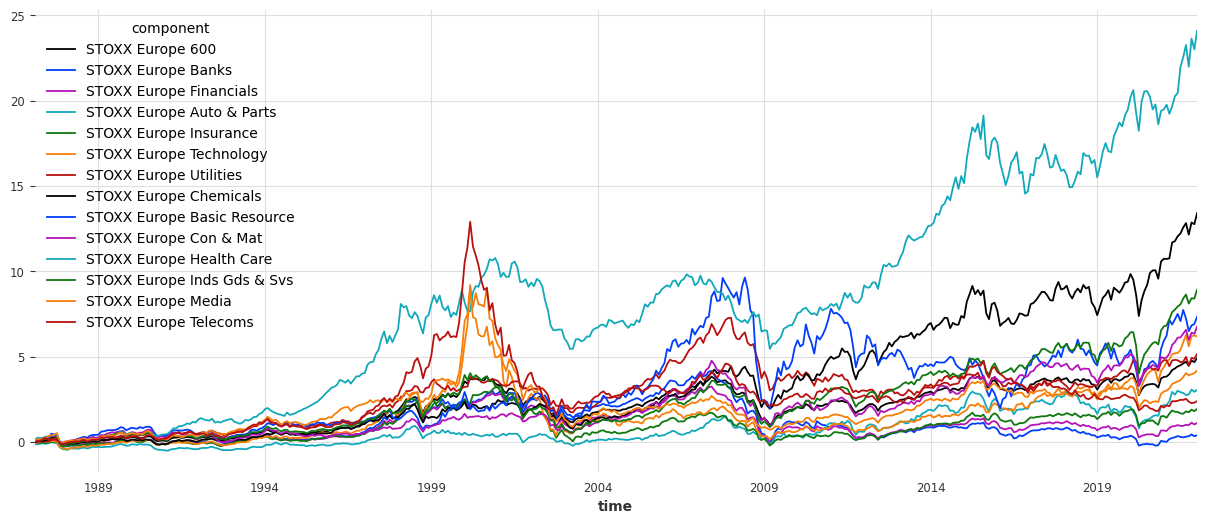

In [5]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

# plot the cumulative returns
cum_returns.plot(figsize=(15, 6));

In [78]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)
#cum_returns

In [79]:
# show the average cumulative monthly return for all assets
average_returns = cum_returns.last_values().mean()
average_returns

6.4284077800970225

# Aufbau und Struktur Methoden

Nachdem wir nun die allgemeinen Basics gelegt haben, sprich, die kumulativen returns ermittelt  und das richtige Objekt-Format (Darts TimeSeries) implementiert haben, können wir im nächsten Schritt die zu replizierenden Modelle aufbauen.

Struktur:
1. Shrinkage Methods
2. Dimensionality reduction methods
3. Nonlinear ML methods
4. Combination ML models

## Shrinkage methods:

Darts bietet wie erwähnt standardisierte Modelle an, in denen dann wie von mir verwendet, Sklearn-Methoden als Parameter eingebaut werden können.

Zunächst wurde den verwendeten Parametern keine tiefere Beachtung geschenkt, um vorerst lediglich die Modelle strukturiert aufzubauen. Mittlerweile konnte ich bereits die Hyperparameter tunen, weshalb bereits die optimierten Parameter verwendet wurden. Zudem findet eine Performance-Bewertung mittels MAPE, R2, MASE und MSE statt.

In [80]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

### Linear Regression

In [81]:
# linear regression model
linear_regression = LinearRegressionModel(
    lags=1
    ) # output chunks standard is 1
linear_regression.fit(series=train)
linear_forecast = linear_regression.predict(len(test))

In [82]:
# print mape, r2 score, mase, mse
print('The linear regression model has the following performance:')
print('MAPE: ', mape(test, linear_forecast))
print('R2 score: ', r2_score(test, linear_forecast))
print('MASE: ', mase(test, linear_forecast, train))
print('MSE: ', mse(test, linear_forecast))

The linear regression model has the following performance:
MAPE:  45.6910638145044
R2 score:  -2.2957597761969004
MASE:  8.323047402392989
MSE:  2.806474889968858


In [83]:
mean_return_lm = linear_forecast.last_values().mean()
mean_return_lm

6.552746050557737

### Ridge Regression

In [84]:
# ridge regression model
ridge_regression = RegressionModel(lags=10, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=0.2))
ridge_regression.fit(train)
ridge_forecast = ridge_regression.predict(len(test))

In [85]:
# print mape, r2 score, mase, mse
print('The ridge regression model has the following performance:')
print('MAPE: ', mape(test, ridge_forecast))
print('R2 score: ', r2_score(test, ridge_forecast))
print('MASE: ', mase(test, ridge_forecast, train))
print('MSE: ', mse(test, ridge_forecast))

The ridge regression model has the following performance:
MAPE:  41.55802669199635
R2 score:  -5.068838539421969
MASE:  9.627630394393538
MSE:  4.725884525738499


In [86]:
mean_return_rr = ridge_forecast.last_values().mean()
mean_return_rr

6.384783426402123

### Lasso Regression

In [87]:
# lasso regression model
lasso_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_regression.fit(train)
lasso_forecast = lasso_regression.predict(len(test))

In [88]:
# print mape, r2 score, mase, mse
print('The lasso regression model has the following performance:')
print('MAPE: ', mape(test, lasso_forecast))
print('R2 score: ', r2_score(test, lasso_forecast))
print('MASE: ', mase(test, lasso_forecast, train))
print('MSE: ', mse(test, lasso_forecast))

The lasso regression model has the following performance:
MAPE:  47.254194805064294
R2 score:  -2.2771490522630278
MASE:  8.436662088188536
MSE:  2.908666702658795


In [89]:
mean_return_lr = lasso_forecast.last_values().mean()
mean_return_lr

6.722919585630254

### Elastic Net

In [90]:
# elastic net regression model
elastic_net_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_net_regression.fit(train)
elastic_net_forecast = elastic_net_regression.predict(len(test))

In [91]:
# print mape, r2 score, mase, mse
print('The elastic net regression model has the following performance:')
print('MAPE: ', mape(test, elastic_net_forecast))
print('R2 score: ', r2_score(test, elastic_net_forecast))
print('MASE: ', mase(test, elastic_net_forecast, train))
print('MSE: ', mse(test, elastic_net_forecast))

The elastic net regression model has the following performance:
MAPE:  47.254194805064294
R2 score:  -2.2771490522630278
MASE:  8.436662088188536
MSE:  2.908666702658795


In [92]:
mean_return_el = elastic_net_forecast.last_values().mean()
mean_return_el

6.722919585630254

### Bridge Regression

In [159]:
# bridge regression model
bridge_regression = RegressionModel(lags=3, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=9))
bridge_regression.fit(train)
bridge_forecast = bridge_regression.predict(len(test))

In [160]:
# print mape, r2 score, mase, mse
print('The bridge regression model has the following performance:')
print('MAPE: ', mape(test, bridge_forecast))
print('R2 score: ', r2_score(test, bridge_forecast))
print('MASE: ', mase(test, bridge_forecast, train))
print('MSE: ', mse(test, bridge_forecast))

The bridge regression model has the following performance:
MAPE:  25.117259069135198
R2 score:  -0.8880513431063024
MASE:  5.886945764114152
MSE:  2.1140587608315626


In [161]:
mean_return_br = bridge_forecast.last_values().mean()
mean_return_br

4.236785466687627

### Plots

Die Plots sind natürlich extrem unübersichtlich, da ich bisher alle gemessenen und vorhergesagten Werte für 14 Variablen plotte. Dies würde ich zu einem späteren Zeitpunkt übersichtlicher gestalten. (Mal abgesehen davon, dass Python mir hier nur 10 von 14 Variablen in die Plots einbezieht). Die Trends sind dennoch deutlich zu erkennen.

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

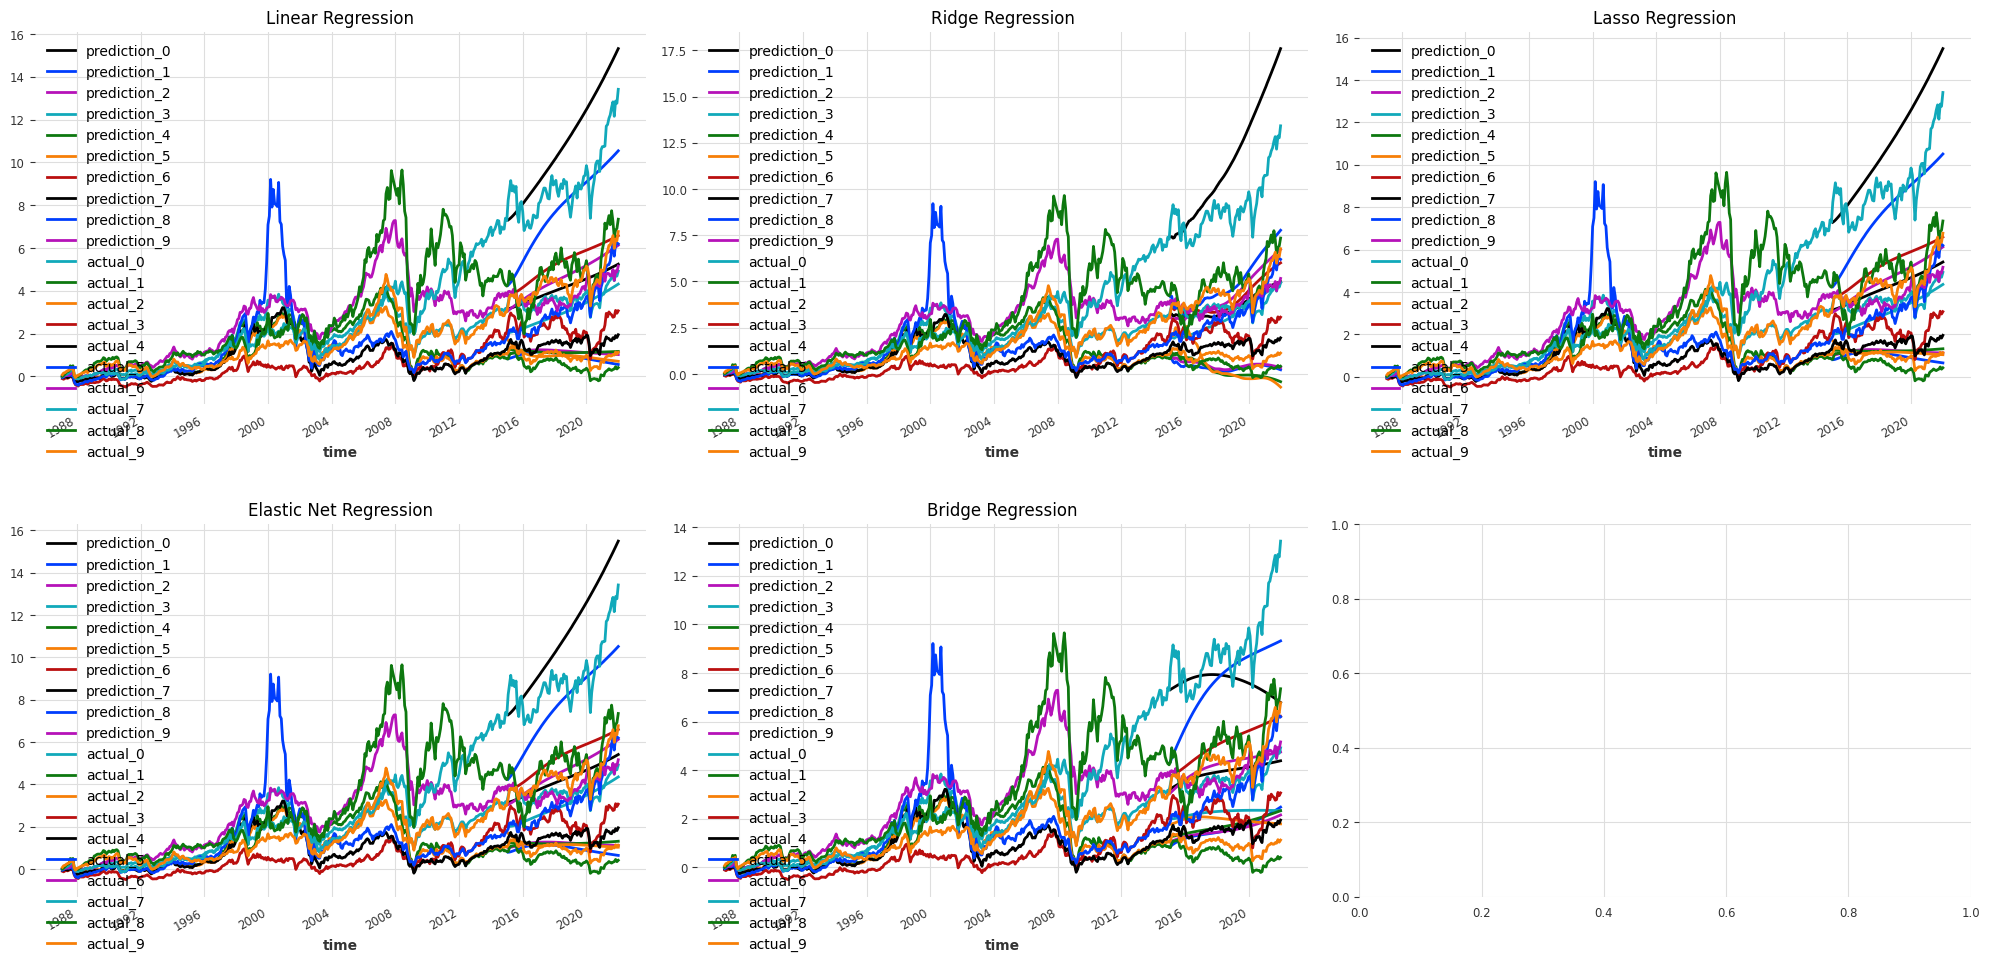

In [96]:
# Plot the predictions
shrinkage_forecasts = {'Linear Regression': linear_forecast,
                       'Ridge Regression': ridge_forecast,
                       'Lasso Regression': lasso_forecast,
                       'Elastic Net Regression': elastic_net_forecast,
                       'Bridge Regression': bridge_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(shrinkage_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

## Dimensionality reduction methods

### PLS Regression

In [169]:
# pls regression model
pls_regression = RegressionModel(lags=58, output_chunk_length=1, model= sklearn.cross_decomposition.PLSRegression(n_components=4))
pls_regression.fit(train)
pls_forecast = pls_regression.predict(len(test))

In [170]:
# print mape, r2 score, mase, mse
print('The pls regression model has the following performance:')
print('MAPE: ', mape(test, pls_forecast))
print('R2 score: ', r2_score(test, pls_forecast))
print('MASE: ', mase(test, pls_forecast, train))
print('MSE: ', mse(test, pls_forecast))

The pls regression model has the following performance:
MAPE:  32.958365480549126
R2 score:  -2.8965094627620642
MASE:  9.061195263858792
MSE:  3.848061887338684


In [171]:
mean_return_pls = pls_forecast.last_values().mean()
mean_return_pls

3.6753061044688695

### PLS Canonical

In [173]:
# pls canonical regression model
pls_canonical = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSCanonical(n_components=3))
pls_canonical.fit(train)
pls_canonical_forecast = pls_canonical.predict(len(test))

In [174]:
# print mape, r2 score, mase, mse
print('The pls canonical regression model has the following performance:')
print('MAPE: ', mape(test, pls_canonical_forecast))
print('R2 score: ', r2_score(test, pls_canonical_forecast))
print('MASE: ', mase(test, pls_canonical_forecast, train))
print('MSE: ', mse(test, pls_canonical_forecast))

The pls canonical regression model has the following performance:
MAPE:  37.470971689130295
R2 score:  -4.773536396459083
MASE:  7.390673819796626
MSE:  2.7788201122553096


In [175]:
mean_return_can = pls_canonical_forecast.last_values().mean()
mean_return_can

5.926675662970831

### CCA

In [103]:
# cca regression model
cca = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.CCA(n_components=1))
cca.fit(train)
cca_forecast = cca.predict(len(test))

In [104]:
# print mape, r2 score, mase, mse
print('The cca regression model has the following performance:')
print('MAPE: ', mape(test, cca_forecast))
print('R2 score: ', r2_score(test, cca_forecast))
print('MASE: ', mase(test, cca_forecast, train))
print('MSE: ', mse(test, cca_forecast))

The cca regression model has the following performance:
MAPE:  88.61602341891123
R2 score:  -5.533738481763187
MASE:  9.99842821577712
MSE:  3.5796015503866454


In [105]:
mean_return_cca = cca_forecast.last_values().mean()
mean_return_cca

4.541832920118693

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

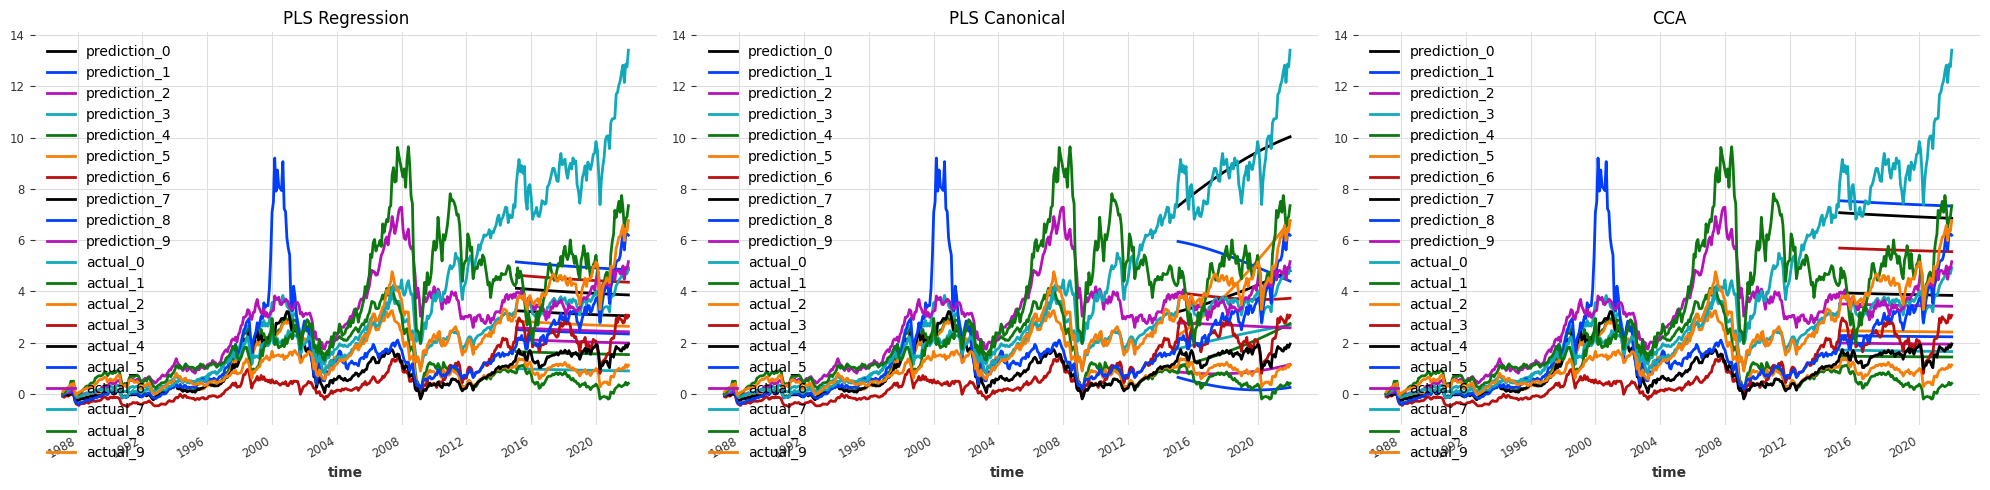

In [106]:
# Plot the predictions
dimensionality_forecasts = {'PLS Regression': pls_forecast,
                            'PLS Canonical': pls_canonical_forecast,
                            'CCA': cca_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(dimensionality_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

## Nonlinear ML methods

### Random Forest

In [107]:
# random forest model
random_forest = RandomForest(lags=76, output_chunk_length=1, n_estimators=2)
random_forest.fit(train)
random_forest_forecast = random_forest.predict(len(test))

In [108]:
# print mape, r2 score, mase, mse
print('The random forest model has the following performance:')
print('MAPE: ', mape(test, random_forest_forecast))
print('R2 score: ', r2_score(test, random_forest_forecast))
print('MASE: ', mase(test, random_forest_forecast, train))
print('MSE: ', mse(test, random_forest_forecast))

The random forest model has the following performance:
MAPE:  60.15708122237738
R2 score:  -6.022130356104491
MASE:  13.95447380680092
MSE:  8.625253102657336


In [109]:
mean_return_rf = random_forest_forecast.last_values().mean()
mean_return_rf

2.8263297553588766

### Gradient Boosting Regressor

In [110]:
# gradient boosting model
gb_boosting = RegressionModel(lags=1, output_chunk_length=1, 
                              model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0))
gb_boosting.fit(train)
gb_boosting_forecast = gb_boosting.predict(len(test))

In [111]:
# print mape, r2 score, mase, mse
print('The gradient boosting model has the following performance:')
print('MAPE: ', mape(test, gb_boosting_forecast))
print('R2 score: ', r2_score(test, gb_boosting_forecast))
print('MASE: ', mase(test, gb_boosting_forecast, train))
print('MSE: ', mse(test, gb_boosting_forecast))

The gradient boosting model has the following performance:
MAPE:  42.43103081371945
R2 score:  -1.4855227622854559
MASE:  7.764344100456843
MSE:  2.5904553024375856


In [112]:
mean_return_gb = gb_boosting_forecast.last_values().mean()
mean_return_gb

3.8297386225345957

### Ada Boosting Regressor

In [113]:
# ada boosting model
ada_boosting = RegressionModel(lags=1, output_chunk_length=1,
                                 model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0))
ada_boosting.fit(train)
ada_boosting_forecast = ada_boosting.predict(len(test))

In [114]:
# print mape, r2 score, mase, mse
print('The ada boosting model has the following performance:')
print('MAPE: ', mape(test, ada_boosting_forecast))
print('R2 score: ', r2_score(test, ada_boosting_forecast))
print('MASE: ', mase(test, ada_boosting_forecast, train))
print('MSE: ', mse(test, ada_boosting_forecast))

The ada boosting model has the following performance:
MAPE:  41.655722798816086
R2 score:  -1.3705996912959197
MASE:  7.579137478631095
MSE:  2.571411769776421


In [115]:
mean_return_adab = ada_boosting_forecast.last_values().mean()
mean_return_adab

3.833027075881031

### Extra Trees Regressor

In [116]:
# extra tree regression model
extra_tree = RegressionModel(lags=1, output_chunk_length=1,
                                    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
extra_tree.fit(train)
extra_tree_forecast = extra_tree.predict(len(test))

In [117]:
# print mape, r2 score, mase, mse
print('The extra tree regression model has the following performance:')
print('MAPE: ', mape(test, extra_tree_forecast))
print('R2 score: ', r2_score(test, extra_tree_forecast))
print('MASE: ', mase(test, extra_tree_forecast, train))
print('MSE: ', mse(test, extra_tree_forecast))

The extra tree regression model has the following performance:
MAPE:  37.617834600263556
R2 score:  -1.095428780620034
MASE:  7.153755225947052
MSE:  2.340890552086862


In [118]:
mean_return_et = extra_tree_forecast.last_values().mean()
mean_return_et

3.855870430456567

### Support Vector Regression

In [119]:
# support vector regression model
svr = RegressionModel(lags=1, output_chunk_length=1,
                                model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))
svr.fit(train)
svr_forecast = svr.predict(len(test))

In [120]:
# print mape, r2 score, mase, mse
print('The support vector regression model has the following performance:')
print('MAPE: ', mape(test, svr_forecast))
print('R2 score: ', r2_score(test, svr_forecast))
print('MASE: ', mase(test, svr_forecast, train))
print('MSE: ', mse(test, svr_forecast))

The support vector regression model has the following performance:
MAPE:  43.55229666872609
R2 score:  -1.663160512175679
MASE:  8.151721131851815
MSE:  2.9512734730626744


In [121]:
mean_return_sv = svr_forecast.last_values().mean()
mean_return_sv

3.4855685767469686

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

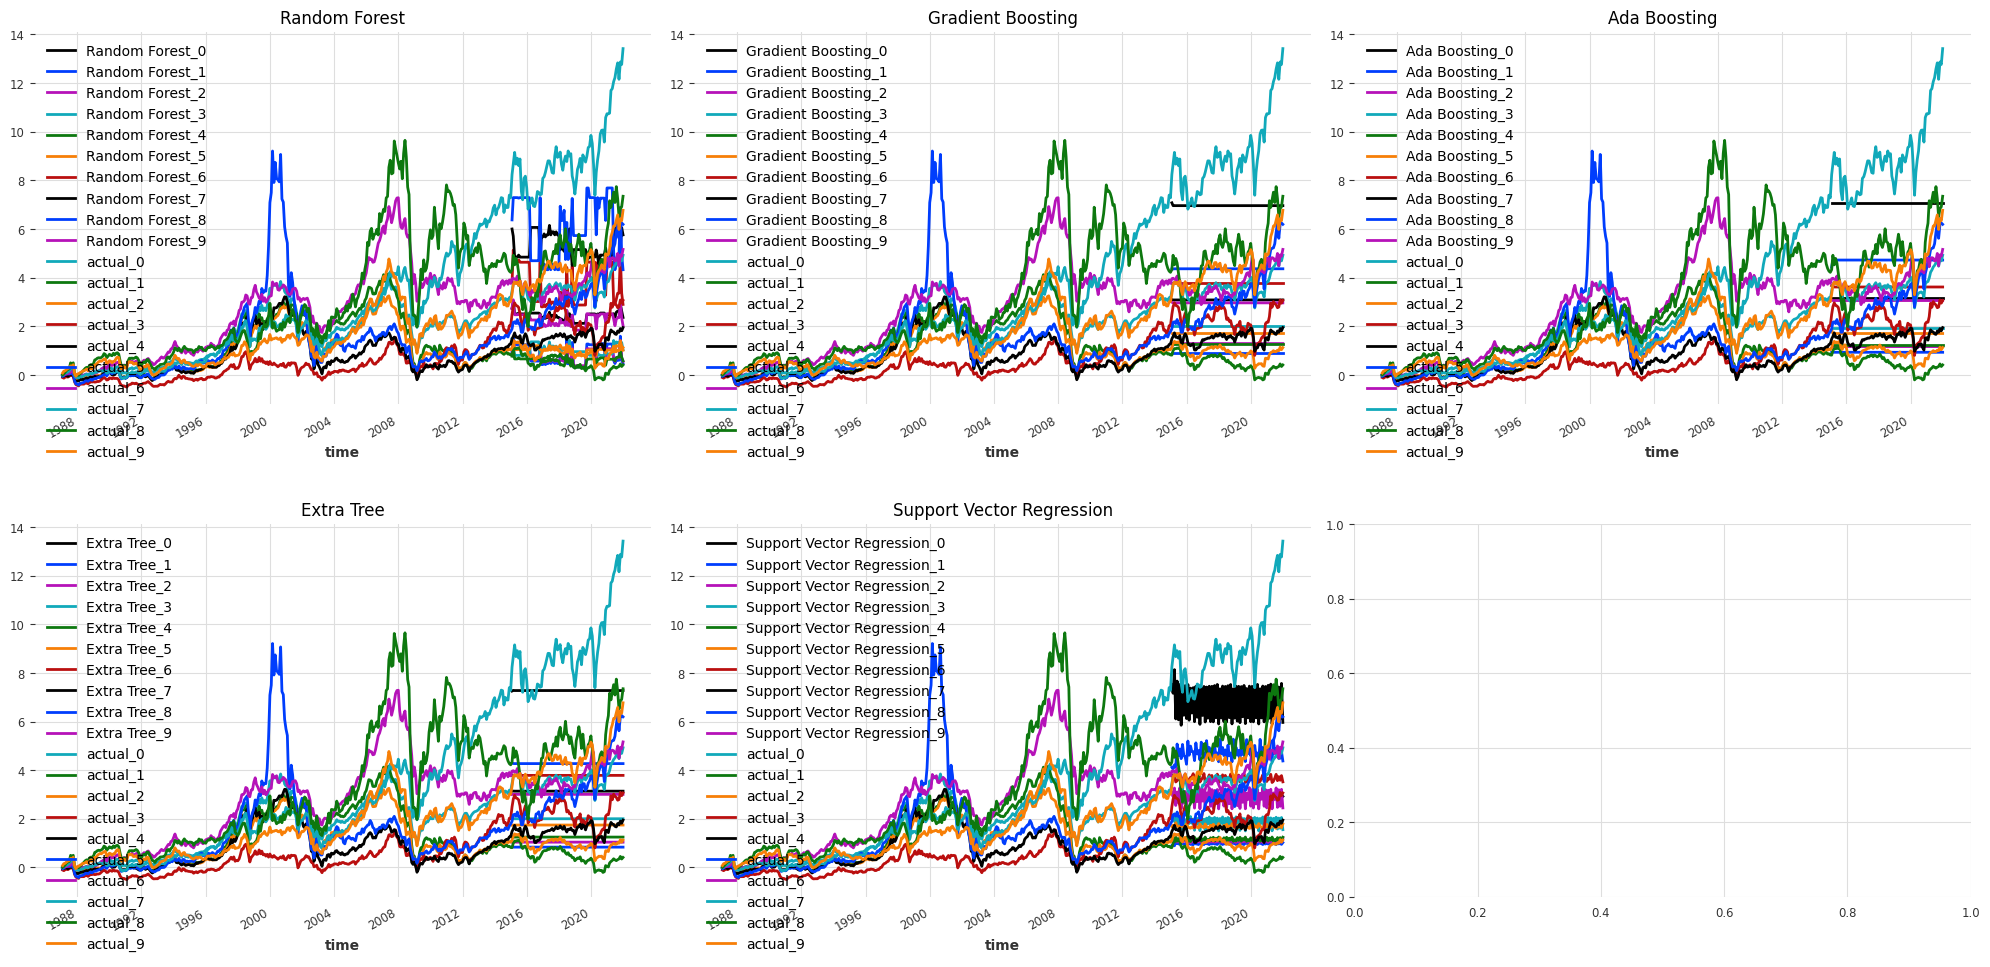

In [122]:
nonlinear_ML_forecasts = {'Random Forest': random_forest_forecast,
                          'Gradient Boosting': gb_boosting_forecast,
                          'Ada Boosting': ada_boosting_forecast,
                          'Extra Tree': extra_tree_forecast,
                          'Support Vector Regression': svr_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(nonlinear_ML_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

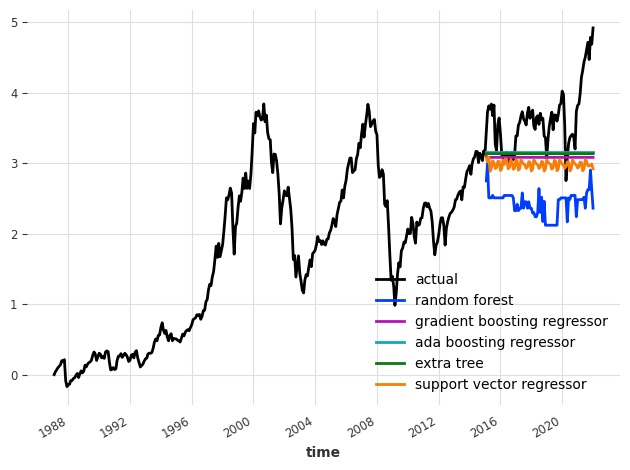

In [123]:
# plot only the outcome of the benchmark
cum_returns["STOXX Europe 600"].plot(label='actual')
random_forest_forecast["STOXX Europe 600"].plot(label="random forest")
gb_boosting_forecast["STOXX Europe 600"].plot(label="gradient boosting regressor")
ada_boosting_forecast["STOXX Europe 600"].plot(label="ada boosting regressor")
extra_tree_forecast["STOXX Europe 600"].plot(label="extra tree")
svr_forecast["STOXX Europe 600"].plot(label="support vector regressor")
    
plt.tight_layout();

## Combination ML methods

### Combination Shrinkage

In [124]:
# ensemble of regression models
shrinkage_ensemble = [LinearRegressionModel(lags=1, output_chunk_length=1),
                      RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))]

In [125]:
shrinkage_ensemble_model = RegressionEnsembleModel(forecasting_models=shrinkage_ensemble, regression_train_n_points=100)
shrinkage_ensemble_model.fit(train)
shrinkage_ensemble_forecast = shrinkage_ensemble_model.predict(len(test))

In [126]:
# print mape, r2 score, mase, mse
#print('The shrinkage ensemble model has the following performance:')
#print('MAPE: ', mape(test, shrinkage_ensemble_forecast))
#print('R2 score: ', r2_score(test, shrinkage_ensemble_forecast))
#print('MASE: ', mase(test, shrinkage_ensemble_forecast, train))
#print('MSE: ', mse(test, shrinkage_ensemble_forecast))

In [127]:
#mean_return_c_shrinkage = shrinkage_ensemble_forecast.last_values().mean()
#mean_return_c_shrinkage

### Combination Dimensionality Reduction

In [128]:
# ensemble of dimsenionality reduction models
dim_ensemble = [RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSRegression(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.CCA(n_components=1))]

In [129]:
dim_ensemble_model = RegressionEnsembleModel(forecasting_models=dim_ensemble, regression_train_n_points=100)
dim_ensemble_model.fit(train)
dim_ensemble_forecast = dim_ensemble_model.predict(len(test))

In [130]:
# print mape, r2 score, mase, mse
print('The dimensionality reduction ensemble model has the following performance:')
print('MAPE: ', mape(test, dim_ensemble_forecast))
print('R2 score: ', r2_score(test, dim_ensemble_forecast))
print('MASE: ', mase(test, dim_ensemble_forecast, train))
print('MSE: ', mse(test, dim_ensemble_forecast))

The dimensionality reduction ensemble model has the following performance:
MAPE:  100.0
R2 score:  -31.48693883109621
MASE:  32.09811514977248
MSE:  39.693017331483404


In [131]:
mean_return_c_dim_ensemble = dim_ensemble_forecast.last_values().mean()
mean_return_c_dim_ensemble

1.491229483401007e-22

### Combination Nonlinear ML

In [132]:
# ensemble of nonlinear models
nonlinear_ensemble = [RandomForest(lags=76, output_chunk_length=1, n_estimators=2),
                        RegressionModel(lags=100, output_chunk_length=1, model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))]

In [133]:
nonlinear_ensemble_model = RegressionEnsembleModel(forecasting_models=nonlinear_ensemble, regression_train_n_points=100)
nonlinear_ensemble_model.fit(train)
nonlinear_ensemble_forecast = nonlinear_ensemble_model.predict(len(test))

In [134]:
# print mape, r2 score, mase, mse
#print('The nonlinear ensemble model has the following performance:')
#print('MAPE: ', mape(test, nonlinear_ensemble_forecast))
#print('R2 score: ', r2_score(test, nonlinear_ensemble_forecast))
#print('MASE: ', mase(test, nonlinear_ensemble_forecast, train))
#print('MSE: ', mse(test, nonlinear_ensemble_forecast))

In [135]:
#mean_return_c_nonlinear = nonlinear_ensemble_forecast.last_values().mean()
#mean_return_c_nonlinear

### Plots

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

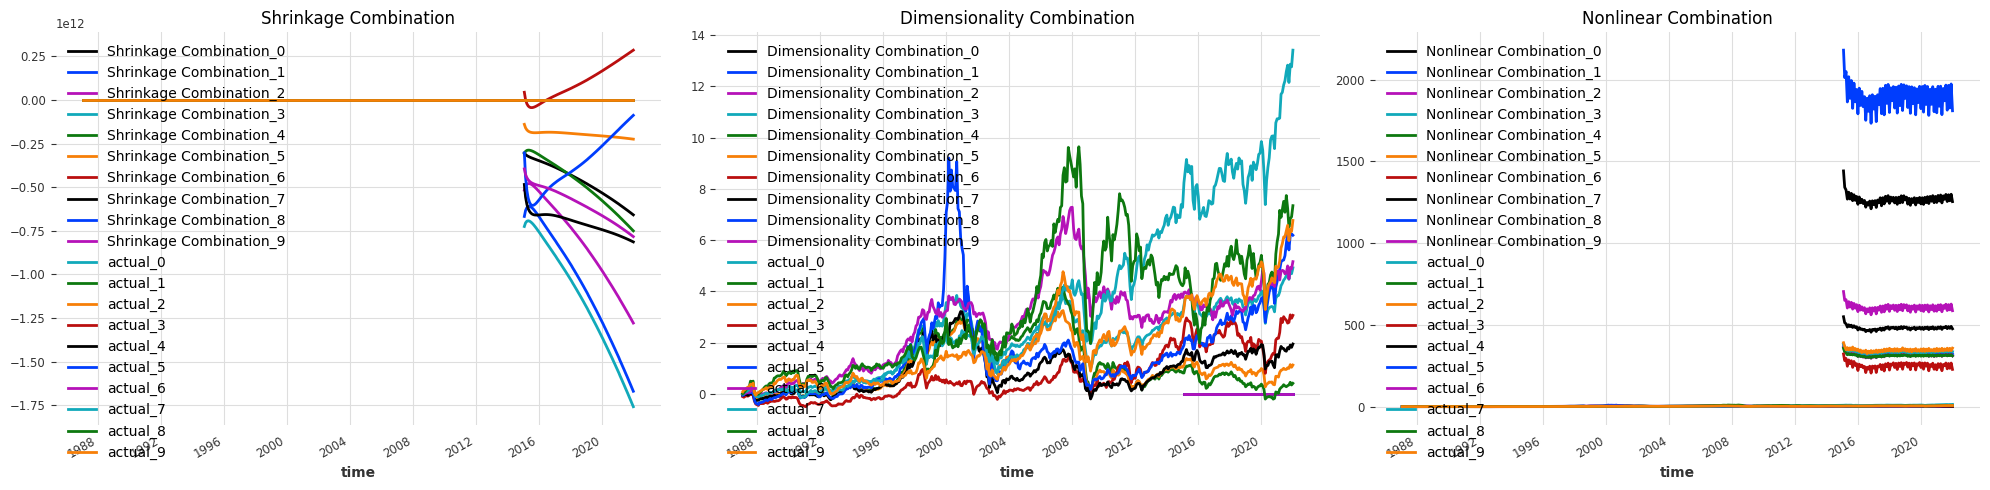

In [136]:
combination_forecasts = {'Shrinkage Combination': shrinkage_ensemble_forecast,
                         'Dimensionality Combination': dim_ensemble_forecast,
                         'Nonlinear Combination': nonlinear_ensemble_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(combination_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

## Auswertung

Nachdem sowohl die Mittelwerte der jeweiligen Portfolios im Vergleich zum Mittelwert der kumulativen Returns des Ursprungportfolios eher schlecht abgeschnitten haben, ist im folgenden Schritt das Hyperparameter Tuning logisch. Zudem ist offensichtlich in der Zusammenstellung der Kombinationen ein Fehler, mindestens im Plotting (die einzelnen Plots habe ich geprüft und legen keine Fehler in der Berechnung offen).

Hyperparameter Tuning ist ein Prozess (bzw. ein Optimierungsproblem), bei dem die Leistung eines maschinellen Lernmodells verbessert wird, indem verschiedene Kombinationen von Hyperparametern ausprobiert werden, um die besten Einstellungen für das Modell zu finden.

# Hyperparameter Tuning .gridSearch()

Darts bietet hierfür die .gridsearch() Funktion an. Jedes Prognosemodell in Darts bietet eine gridsearch()-Methode für die grundlegende Hyperparametersuche. Diese Methode ist auf sehr einfache Fälle mit sehr wenigen Hyperparametern beschränkt und arbeitet nur mit einer einzigen Zeitreihe.
Somit bietet sich in unserem Fall nicht die Nutzung der .gridearch() Funktion an, da wir mit mehreren Zeitreihen arbeiten.

Überlegen wir uns nochmal welche Paramter überhaupt in der Funktion für zunächst die lineare Regression stecken und planen basierend auf diesen Informationen und den Angeboten in Darts eine Optimierungsmethode für Hyperparameter:

- lags=None: gibt an, wie viele vergangene Zeitpunkte in die Vorhersage eines bestimmten Zeitpunkts einbezogen werden sollen
- lags_past_covariates=None: Eine Liste von Verzögerungen für vergangene Kovariablen, die als Eingabe für das Modell verwendet werden sollen. Kovariablen sind zusätzliche Variablen, die zur Vorhersage der Zielvariable beitragen können.
- lags_future_covariates=None: Eine Liste von Verzögerungen für zukünftige Kovariablen, die als Eingabe für das Modell verwendet werden sollen.
- output_chunk_length=1: gibt an, wie viele zukünftige Zeitpunkte in einem einzigen Vorhersageschritt vorhergesagt werden sollen
- add_encoders=None: Encoders sind Funktionen, die Kovariablen in eine numerische Darstellung umwandeln, die als Eingabe für das Modell verwendet werden kann
- likelihood=None: Standardwerte sind None, was bedeutet, dass die Normalverteilung als Standard-Likelihood-Funktion verwendet wird.
- quantiles=None: Eine Liste von Quantilen, die zur Berechnung von Quantilsregressionen verwendet werden sollen
- random_state=None: Seed, der für die Initialisierung der Modellparameter verwendet werden soll.
- multi_models=True: Boolean, der angibt, ob das Modell für jede Spalte in der Eingabe eine separate lineare Regression durchführen soll
- use_static_covariates=True: Boolean, der angibt, ob statische Kovariablen in das Modell einbezogen werden sollen. Statische Kovariablen sind Kovariablen, die für jeden Zeitpunkt in der Zeitreihe gleich bleiben.

Folgende Parameter sind mEn für die ersten Schritte von Relevanz: lags, output_chunk_length = 1. Wichtig ist somit vorerst nur, wie viele vergangene Monatswerte in die Vorhersage einbezogen werden. Eine Vorhersage von einem Zukunftszeitpunkt ist vorerst ausreichend.

Use Linear Regression as benchmark and test

LinearRegressionModel(lags=None, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

classmethod gridsearch(parameters, series, past_covariates=None, future_covariates=None, forecast_horizon=None, stride=1, start=0.5, last_points_only=False, show_warnings=True, val_series=None, use_fitted_values=False, metric=<function mape>, reduction=<function mean>, verbose=False, n_jobs=1, n_random_samples=None)


past covariates in the linear regression model refer to variables that are used as additional inputs in addition to the past values of the target time series for predicting its future values. These variables can be other time series that have a relationship with the target time series. The lags_past_covariates parameter in the LinearRegressionModel constructor is used to specify the number of time steps in the past of the past covariates to be used in the model. The past covariates should also be provided as a TimeSeries object with the same frequency as the target time series.

## Hyperparameter Shrinkage Methods

### Tuning Linear Regression

In [137]:
hyperparameter_linear = {
    "lags": list(range(1,101))
}

In [138]:
tuning_linear = LinearRegressionModel.gridsearch(
    parameters= hyperparameter_linear,
    series= train, # The target series used as input and target for training.
    val_series= test,
    start= 0.1, # represents the starting point in the time index of series from which predictions will be made to evaluate the model
    metric= mape, # function that takes actual and prediction, and returns a float error value
    n_jobs= -1, # setting the parameter to -1 means using all the available cores
    verbose= True # whether to print progress
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [139]:
best_model, best_params = tuning_linear[0], tuning_linear[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('likelihood', None),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Ridge Regression
How to test this when the model includes another sklearn model.

In [140]:
hyperparameter_ridge = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.linear_model.Ridge(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [141]:
ridge_regression_tune = RegressionModel(
    lags= hyperparameter_ridge['lags'][0],
    model=sklearn.linear_model.Ridge(0)
)

In [142]:
tuning_ridge = ridge_regression_tune.gridsearch(
    parameters= hyperparameter_ridge,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.2068e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=9.26853e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.

In [143]:
best_model, best_params = tuning_ridge[0], tuning_ridge[1]
best_model.model_params

OrderedDict([('lags', 10),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Ridge(alpha=0.2)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Lasso Regression

In [144]:
hyperparameter_lasso = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.linear_model.Lasso(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [145]:
lasso_regression_tune = RegressionModel(
    lags= hyperparameter_lasso['lags'][0],
    model=sklearn.linear_model.Lasso(0)
)

In [146]:
tuning_lasso = lasso_regression_tune.gridsearch(
    parameters= hyperparameter_lasso,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [147]:
best_model, best_params = tuning_lasso[0], tuning_lasso[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Lasso(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Elastic Net

In [148]:
hyperparameter_elastic = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [149]:
elastic_net_tune = RegressionModel(
    lags= hyperparameter_elastic['lags'][0],
    model=sklearn.linear_model.ElasticNet(0)
)

In [150]:
tuning_elastic_net = elastic_net_tune.gridsearch(
    parameters= hyperparameter_elastic,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1100 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [151]:
best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]
# print the best model parameters
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', ElasticNet(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning Bridge Regression

In [152]:
hyperparameter_bridge = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.linear_model.LassoLarsCV(cv=c) for c in np.arange(2, 10, 1)
    ]
}

In [153]:
bridge_regression_tune = RegressionModel(
    lags= hyperparameter_bridge['lags'][0],
    model=sklearn.linear_model.LassoLarsCV(cv=0)
)

In [154]:
tuning_bridge = bridge_regression_tune.gridsearch(
    parameters= hyperparameter_bridge,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/800 [00:00<?, ?it/s]

In [155]:
best_model, best_params = tuning_bridge[0], tuning_bridge[1]
# print the best model parameters
best_model.model_params

OrderedDict([('lags', 3),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', LassoLarsCV(cv=9)),
             ('multi_models', True),
             ('use_static_covariates', True)])

## Hyperparameter Dimensionality Reduction

### Tuning PLS Regression

In [162]:
hyperparameter_pls = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.cross_decomposition.PLSRegression(n_components=n) for n in np.arange(1, 15, 1)
    ]
}

In [163]:
pls_regression_tune = RegressionModel(
    lags= hyperparameter_pls['lags'][0],
    model=sklearn.cross_decomposition.PLSRegression(n_components=0)
)

In [164]:
tuning_pls = pls_regression_tune.gridsearch(
    parameters= hyperparameter_pls,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [165]:
# print the best model parameters
best_model, best_params = tuning_pls[0], tuning_pls[1]
best_model.model_params

OrderedDict([('lags', 58),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSRegression(n_components=4)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning PLS Canonical

In [166]:
hyperparameter_canonical = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.cross_decomposition.PLSCanonical(n_components=beta) for beta in np.arange(1,15,1)
    ]
}

In [186]:
# pls canonical regression model
pls_canonical_tune = RegressionModel(
    lags=hyperparameter_canonical['lags'][0], 
    model= sklearn.cross_decomposition.PLSCanonical(n_components=0)
    )

In [187]:
tuning_canonical = pls_canonical_tune.gridsearch(
    parameters= hyperparameter_canonical,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [188]:
best_model, best_params = tuning_canonical[0], tuning_canonical[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', PLSCanonical(n_components=3)),
             ('multi_models', True),
             ('use_static_covariates', True)])

### Tuning CCA

In [189]:
hyperparameter_cca = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.cross_decomposition.CCA(n_components=beta) for beta in np.arange(1,15,1)
    ]
}

In [190]:
cca_tune = RegressionModel(
    lags= hyperparameter_cca['lags'][0],
    model=sklearn.cross_decomposition.CCA(n_components=0)
)

In [191]:
tuning_cca = cca_tune.gridsearch(
    parameters= hyperparameter_cca,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1400 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/antonkruse/.pyenv/ver

In [192]:
# print the best model parameters
best_model, best_params = tuning_cca[0], tuning_cca[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', CCA()),
             ('multi_models', True),
             ('use_static_covariates', True)])

## Hyperparameter Nonlinear ML

### Tuning Random Forest

In [179]:
hyperparameter_randomforest = {
    "lags": list(range(1,101)),
    'n_estimators': list(range(1, 50))
}

In [180]:
random_forest_tune = RandomForest(
    lags=hyperparameter_randomforest['lags'][0], 
    n_estimators=hyperparameter_randomforest['n_estimators'][0]
    )

In [ ]:
tuning_randomforest = random_forest_tune.gridsearch(
    parameters= hyperparameter_randomforest,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

In [ ]:
# print the best model parameters
best_model, best_params = tuning_randomforest[0], tuning_randomforest[1]
best_model.model_params

### Tuning Gradient Boosting Regressor

In [ ]:
hyperparameter_gradient_boosting = {
    "lags": list(range(1,51)),
    'model': [
        GradientBoostingRegressor(n_estimators=n, learning_rate=l, max_depth=m, random_state=0) 
        for n in range(1, 6) 
        for m in range(1, 6)
        for l in np.arange(0.1, 0.7, 0.1)
    ]
}

In [197]:
gradient_boosting_tune = RegressionModel(
    lags= hyperparameter_gradient_boosting['lags'][0],
    model=GradientBoostingRegressor(n_estimators=0, learning_rate=0, max_depth=0, random_state=0)
)

In [ ]:
tuning_gradient_boosting = gradient_boosting_tune.gridsearch(
    parameters= hyperparameter_gradient_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

In [ ]:
# print the best model parameters
best_model, best_params = tuning_gradient_boosting[0], tuning_gradient_boosting[1]
best_model.model_params

### Tuning Ada Boosting Regressor

In [ ]:
hyperparameter_ada_boosting = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.ensemble.AdaBoostRegressor(n_estimators=n, random_state=0) 
        for n in np.arange(1, 10, 1)
    ]
}

In [ ]:
ada_boosting_tune = RegressionModel(
    lags= hyperparameter_ada_boosting['lags'][0],
    model=sklearn.ensemble.AdaBoostRegressor(n_estimators=0, random_state=0)
)

In [ ]:
tuning_ada_boosting = ada_boosting_tune.gridsearch(
    parameters= hyperparameter_ada_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

In [ ]:
# print the best model parameters
best_model, best_params = tuning_ada_boosting[0], tuning_ada_boosting[1]
best_model.model_params

### Tuning Extra Trees Regressor

In [ ]:
hyperparameter_extra_tress = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.ensemble.ExtraTreesRegressor(n_estimators=n, max_depth=m, min_samples_split=s, random_state=0) 
        for n, m, s in np.arange(1, 10, 1)
    ]
}

In [ ]:
extra_trees_tune = RegressionModel(
    lags= hyperparameter_extra_tress['lags'][0],
    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=0, max_depth=0, min_samples_split=0, random_state=0)
)

In [ ]:
tuning_extra_trees = extra_trees_tune.gridsearch(
    parameters= hyperparameter_extra_tress,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

In [ ]:
# print the best model parameters
best_model, best_params = tuning_extra_trees[0], tuning_extra_trees[1]
best_model.model_params

### Tuning Support Vector Regression

In [ ]:
hyperparameter_support_vector = {
    "lags": list(range(1,101)),
    'model': [
        sklearn.svm.SVR(kernel= k, C= , gamma= g) 
        for g in ['scale', 'auto'] AND for k in ['linear', 'poly', 'rbf', 'sigmoid'] AND for c in np.arange(0.1, 1, 0.1)
    ]
}

In [ ]:
support_vector_tune = RegressionModel(
    lags= hyperparameter_support_vector['lags'][0],
    model=sklearn.svm.SVR(kernel= 'linear', C= 0.1, gamma= 'scale')
)

In [ ]:
tuning_support_vector = support_vector_tune.gridsearch(
    parameters= hyperparameter_support_vector,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

In [ ]:
# print the best model parameters
best_model, best_params = tuning_support_vector[0], tuning_support_vector[1]
best_model.model_params

# Questions & Next Steps

Gibt es weitere Hyperparameter die wir optimieren wollen?
- Kovariablen (vergangene und/oder zukünftige; bspw. benchmark)


